<a href="https://colab.research.google.com/github/CarolineVicente/Machine_Learn/blob/main/treinando_uma_rede_neural_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import time
import os


Funções de perda

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [3]:
wine = datasets.load_wine()
data = wine.data
target = wine.target

print(data.shape, target.shape)
print(wine.feature_names, wine.target_names)


(178, 13) (178,)
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'] ['class_0' 'class_1' 'class_2']


In [4]:
class WineClassifier(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(WineClassifier, self).__init__()

    self.hidden  = nn.Linear(input_size, hidden_size)
    self.relu    = nn.ReLU()
    self.out     = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, X):

    feature = self.relu(self.hidden(X))
    output  = self.softmax(self.out(feature))

    return output

input_size  = data.shape[1]
hidden_size = 32
out_size    = len(wine.target_names)

net = WineClassifier(input_size, hidden_size, out_size).to(device)

Classificação


In [5]:
criterion = nn.CrossEntropyLoss().to(device)


In [6]:
Xtns = torch.from_numpy(data).float().to(device)
Ytns = torch.from_numpy(target).to(device)

Xtns = Xtns.to(device)
Ytns = Ytns.to(device)

In [7]:
pred = net(Xtns)
print(Xtns.shape, pred.shape)

torch.Size([178, 13]) torch.Size([178, 3])


In [8]:
print(pred.shape, Ytns.shape)

print(pred[0].data, Ytns[0].data)

torch.Size([178, 3]) torch.Size([178])
tensor([7.9675e-18, 4.7643e-10, 1.0000e+00], device='cuda:0') tensor(0, device='cuda:0')


In [9]:
loss = criterion(pred, Ytns)
print(loss)

tensor(1.2817, device='cuda:0', grad_fn=<NllLossBackward0>)


Regressão

In [10]:
diabetes = datasets.load_diabetes()
data = diabetes.data
target = diabetes.target

print(data.shape, target.shape)

print(data[14])
print(target[14])


(442, 10) (442,)
[ 4.53409833e-02 -4.46416365e-02 -2.56065715e-02 -1.25561242e-02
  1.76943802e-02 -6.12835791e-05  8.17748397e-02 -3.94933829e-02
 -3.19876395e-02 -7.56356220e-02]
118.0


In [11]:
input_size  = data.shape[1]
hidden_size = 32
out_size = 1  # Progressão da diabetes

net = WineClassifier(input_size, hidden_size, out_size).to(device)

In [12]:
criterion = nn.MSELoss().to(device)

Xtns = torch.from_numpy(data).float().to(device)
Ytns = torch.from_numpy(target).float().to(device)

print(Xtns.shape, Ytns.shape)

torch.Size([442, 10]) torch.Size([442])


In [13]:
pred = net(Xtns)

loss = criterion(pred.squeeze(), Ytns)
print(loss.data)


tensor(28771.2168, device='cuda:0')


In [14]:
criterion = nn.L1Loss().to(device)

pred = net(Xtns)

loss = criterion(pred.squeeze(), Ytns)
print(loss.data)

tensor(151.1335, device='cuda:0')


Otimizando a Rede

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


Text(0, 0.5, 'color_intensity')

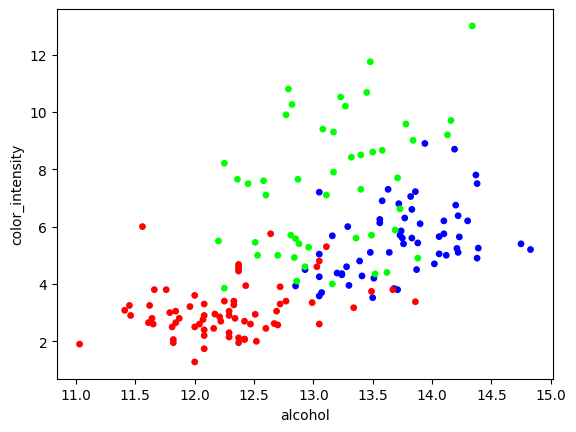

In [15]:
features = [0, 9]

wine = datasets.load_wine()
data = wine.data[:, features]
targets = wine.target

print(wine.feature_names)

plt.scatter(data[:, 0], data[:,1], c=targets, s=15, cmap=plt.cm.brg)

plt.xlabel(wine.feature_names[features[0]])
plt.ylabel(wine.feature_names[features[1]])

Normalização

Text(0, 0.5, 'color_intensity')

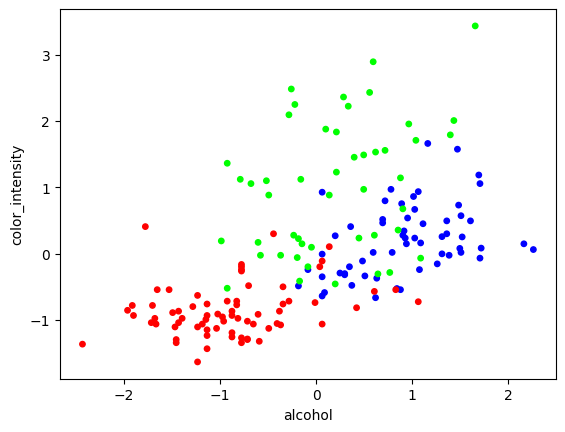

In [16]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

plt.scatter(data[:, 0], data[:,1], c=targets, s=15, cmap=plt.cm.brg)
plt.xlabel(wine.feature_names[features[0]])
plt.ylabel(wine.feature_names[features[1]])

Instanciando a rede

In [17]:
torch.manual_seed(42)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

input_size  = data.shape[1]
hidden_size = 32
out_size = len(wine.target_names) # numero de classes

net = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, out_size),
    nn.Softmax()
)

net = net.to(device)

cuda


Visualizando a fronteira de decisão

In [18]:
def plot_boundary(X, y, model):
  x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
  y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1

  spacing = min(x_max - x_min, y_max - y_min) / 100

  XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                       np.arange(y_min, y_max, spacing))

  data = np.hstack((XX.ravel().reshape(-1,1),
                    YY.ravel().reshape(-1,1)))

  # For binary problems
  # db_prob = model(Variable(torch.Tensor(data)).cuda() )
  # clf = np.where(db_prob.cpu().data < 0.5,0,1)

  # For multi-class problems
  db_prob = model(torch.Tensor(data).to(device) )
  clf = np.argmax(db_prob.cpu().data.numpy(), axis=-1)

  Z = clf.reshape(XX.shape)

  plt.contourf(XX, YY, Z, cmap=plt.cm.brg, alpha=0.5)
  plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', s=25, cmap=plt.cm.brg)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


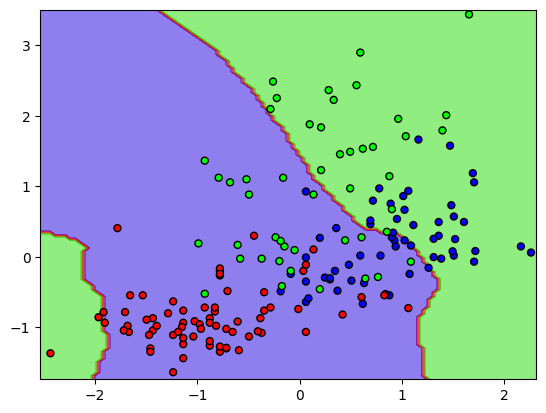

In [19]:
plot_boundary(data, targets, net)

In [20]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-3)

In [23]:
X = torch.FloatTensor(data).to(device)
Y = torch.LongTensor(targets).to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


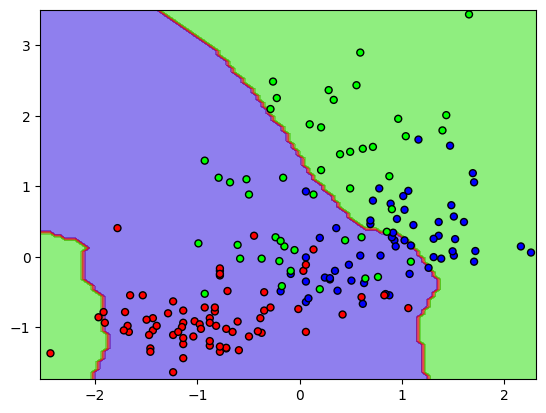

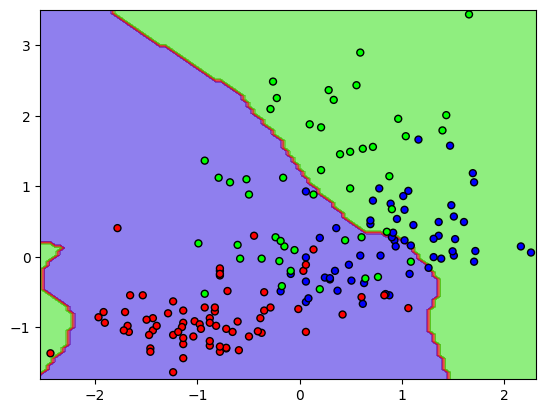

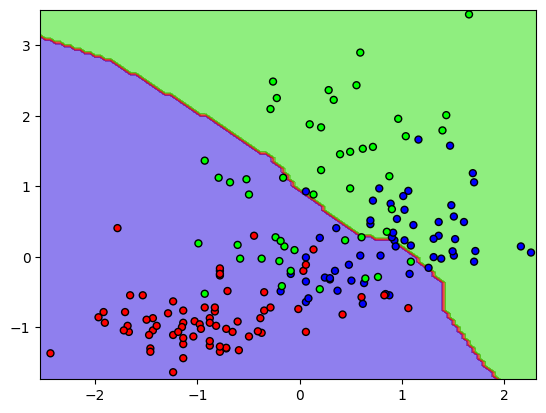

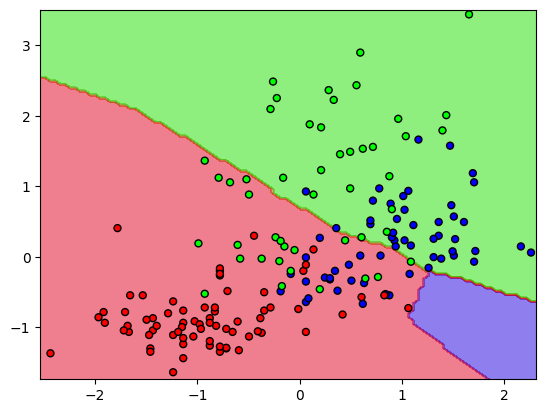

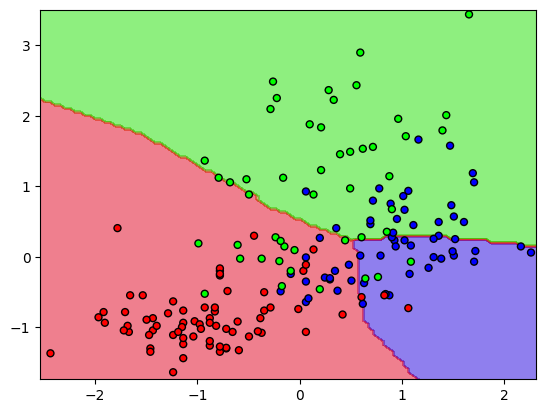

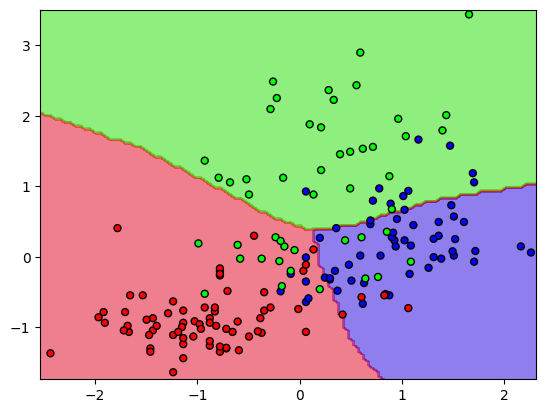

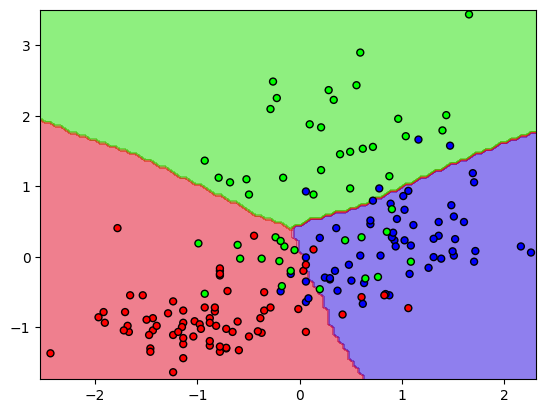

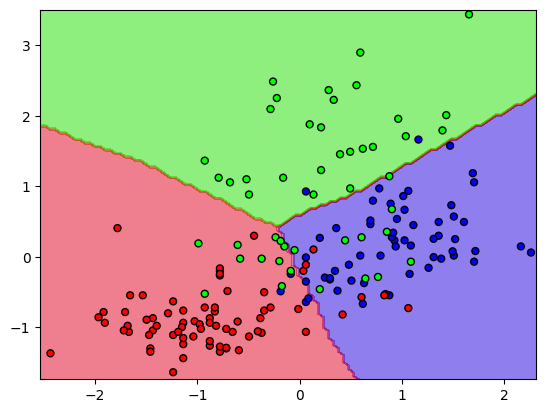

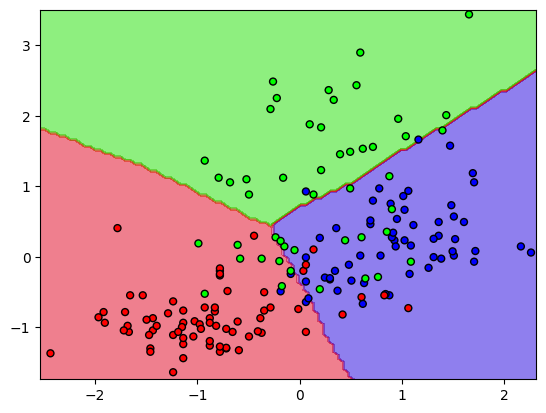

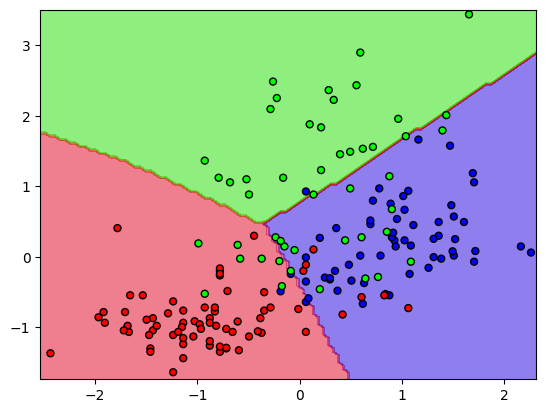

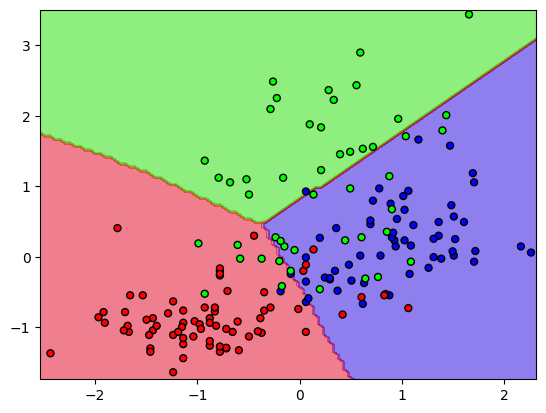

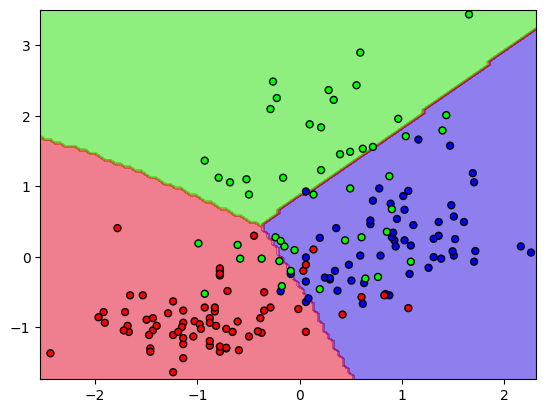

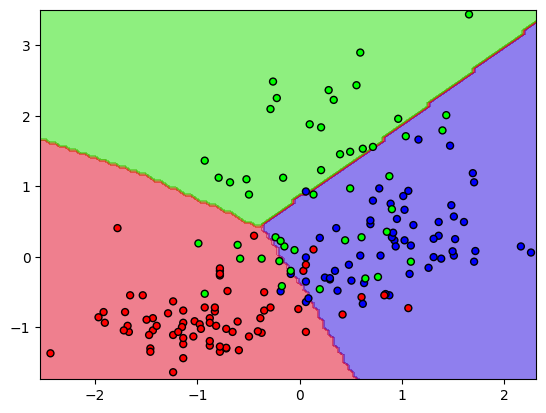

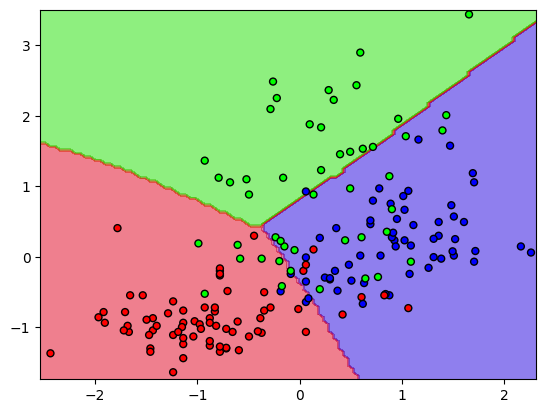

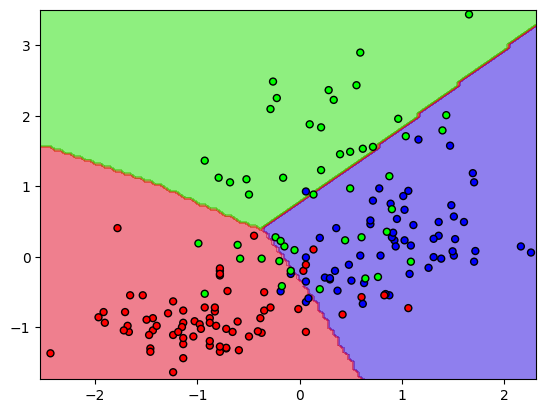

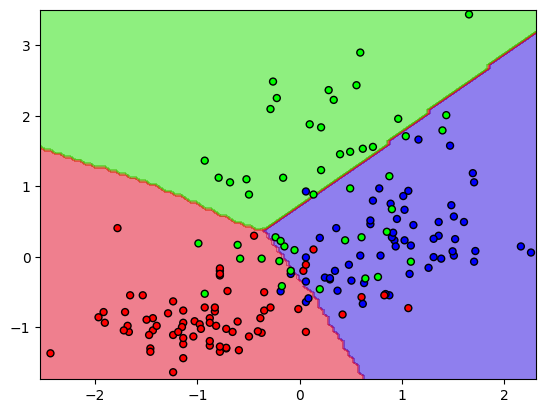

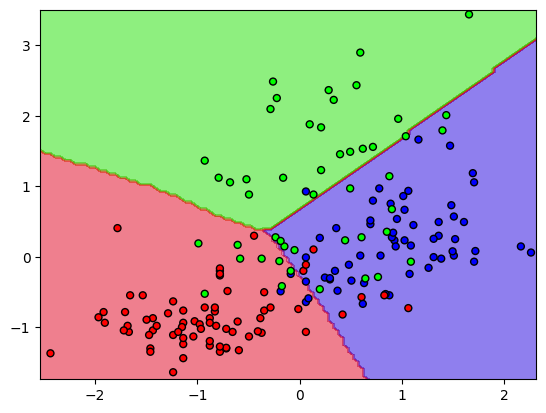

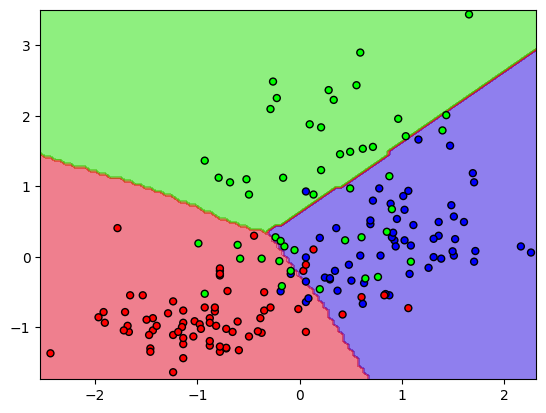

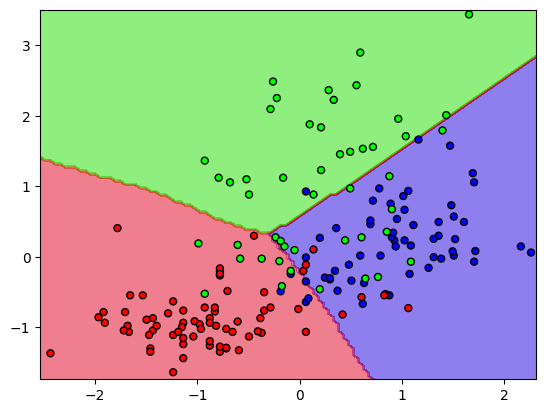

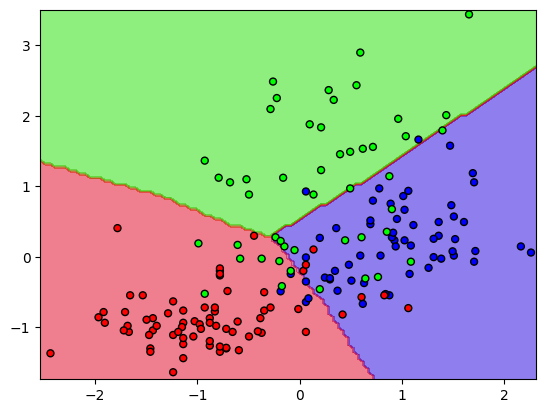

In [24]:
for i in range(200):
  # Forward
  pred = net(X)
  loss = criterion(pred, Y)

  # Backward
  loss.backward()
  optimizer.step()

  if i % 10 == 0:
    plt.figure()
    plot_boundary(data, targets, net)

DataLoader e Fluxo de Treinamento

In [12]:
# Configurando hiperparâmetros.
args = {
    'epoch_num': 200,     # Número de épocas.
    'lr': 5e-5,           # Taxa de aprendizado.
    'weight_decay': 5e-4, # Penalidade L2 (Regularização).
    'num_workers': 3,     # Número de threads do dataloader.
    'batch_size': 20,     # Tamanho do batch.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


In [13]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
! unzip Bike-Sharing-Dataset.zip

--2025-04-14 18:41:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Bike-Sharing-Dataset.zip.1’

Bike-Sharing-Datase     [  <=>               ] 273.43K   809KB/s    in 0.3s    

2025-04-14 18:41:08 (809 KB/s) - ‘Bike-Sharing-Dataset.zip.1’ saved [279992]

Archive:  Bike-Sharing-Dataset.zip
replace Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace day.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace hour.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
df = pd.read_csv('hour.csv')
print(len(df))
df.head()


17379


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [8]:
torch.manual_seed(1)
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))
df_train = df.iloc[indices[:train_size]]
df_test = df.iloc[indices[train_size:]]

print(len(df_train), len(df_test))
display(df_test.head())

df_train.to_csv('bike_train.csv',index=False)
df_test.to_csv('bike_test.csv',index=False)
!ls

13903 3476


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
12663,12664,2012-06-16,2,1,6,20,0,6,0,2,0.66,0.6212,0.47,0.1940,123,229,352
1801,1802,2011-03-20,1,0,3,18,0,0,0,1,0.38,0.3939,0.40,0.3582,58,98,156
16567,16568,2012-11-28,4,1,11,1,0,3,1,2,0.26,0.2576,0.75,0.2239,0,12,12
8817,8818,2012-01-08,1,1,1,5,0,0,0,2,0.32,0.3333,0.49,0.1045,0,2,2
2608,2609,2011-04-23,2,0,4,14,0,6,0,1,0.58,0.5455,0.78,0.3582,182,209,391


Bike-Sharing-Dataset.zip  bike_train.csv  hour.csv    sample_data
bike_test.csv		  day.csv	  Readme.txt


In [9]:
class Bicicletinha(Dataset):
  def __init__(self, csv_path, scaler_feat=None, scaler_label=None):

    self.dados = pd.read_csv(csv_path).to_numpy()

  def __getitem__(self, idx):

    sample = self.dados[idx][2:14]
    label  = self.dados[idx][-1:]

    # converte para tensor
    sample = torch.from_numpy(sample.astype(np.float32))
    label  = torch.from_numpy(label.astype(np.float32))

    return sample, label

  def __len__(self):
    return len(self.dados)

In [10]:
dataset = Bicicletinha('bike_train.csv')
dado, rotulo = dataset[0]
print(rotulo)
print(dado)

tensor([373.])
tensor([ 4.0000,  1.0000, 11.0000, 19.0000,  0.0000,  4.0000,  1.0000,  1.0000,
         0.3800,  0.3939,  0.2700,  0.3582])


In [14]:
train_set = Bicicletinha('bike_train.csv')
test_set  = Bicicletinha('bike_test.csv')

print('Tamanho do treino: ' + str(len(train_set)) + ' amostras')
print('Tamanho do teste: ' + str(len(test_set)) + ' amostras')


Tamanho do treino: 13903 amostras
Tamanho do teste: 3476 amostras


In [15]:
# Criando dataloader
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:

for batch in test_loader:

  dado, rotulo = batch
  print('## Dimensionalidade do batch ##')
  print(dado.size(), rotulo.size())

  break


## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])


In [18]:
class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    self.features = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
    )

    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, out_size),
        nn.ReLU(),
    )

  def forward(self, X):

    hidden = self.features(X)
    output = self.classifier(hidden)

    return output

input_size  = train_set[0][0].size(0)
hidden_size = 128
out_size    = 1

net = MLP(input_size, hidden_size, out_size).to(args['device'])
print(net)


MLP(
  (features): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [19]:
criterion = nn.L1Loss().to(args['device'])

optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [20]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()

  start = time.time()

  epoch_loss  = []
  for batch in train_loader:

    dado, rotulo = batch

    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)

    # Backpropagation
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

  return epoch_loss.mean()

In [21]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()

  start = time.time()

  epoch_loss  = []

  with torch.no_grad():
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

  return epoch_loss.mean()


In [22]:
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):

  # Train
  train_losses.append(train(train_loader, net, epoch))

  # Validate
  test_losses.append(validate(test_loader, net, epoch))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#################### Train ####################
Epoch 0, Loss: 162.7955 +/- 42.8212, Time: 4.67
********** Validate **********
Epoch 0, Loss: 124.4636 +/- 30.0701, Time: 0.81

#################### Train ####################
Epoch 1, Loss: 131.0558 +/- 25.6826, Time: 3.36
********** Validate **********
Epoch 1, Loss: 124.9441 +/- 24.6912, Time: 0.50

#################### Train ####################
Epoch 2, Loss: 122.2494 +/- 30.8971, Time: 3.06
********** Validate **********
Epoch 2, Loss: 124.7811 +/- 31.5689, Time: 2.19

#################### Train ####################
Epoch 3, Loss: 120.3394 +/- 30.4329, Time: 6.03
********** Validate **********
Epoch 3, Loss: 119.2971 +/- 26.3333, Time: 0.50

#################### Train ####################
Epoch 4, Loss: 118.8266 +/- 27.4588, Time: 2.99
********** Validate **********
Epoch 4, Loss: 115.3685 +/- 28.9832, Time: 0.49

#################### Train ####################
Epoch 5, Loss: 119.3803 +/- 30.1465, Time: 4.45
********** Validate ****

In [25]:
Xtest = torch.stack([tup[0] for tup in test_set])
Xtest = Xtest.to(args['device'])

ytest = torch.stack([tup[1] for tup in test_set])
ypred = net(Xtest).cpu().data

data = torch.cat((ytest, ypred), axis=1)

df_results = pd.DataFrame(data, columns=['ypred', 'ytest'])
df_results.head(20)

,ypred,ytest
0,352.0,340.046204
1,156.0,95.067596
2,12.0,8.191463
3,2.0,54.894100
4,391.0,223.241837
5,391.0,261.877075
6,84.0,199.942032
7,487.0,525.175537
8,176.0,198.048080
9,157.0,88.965607


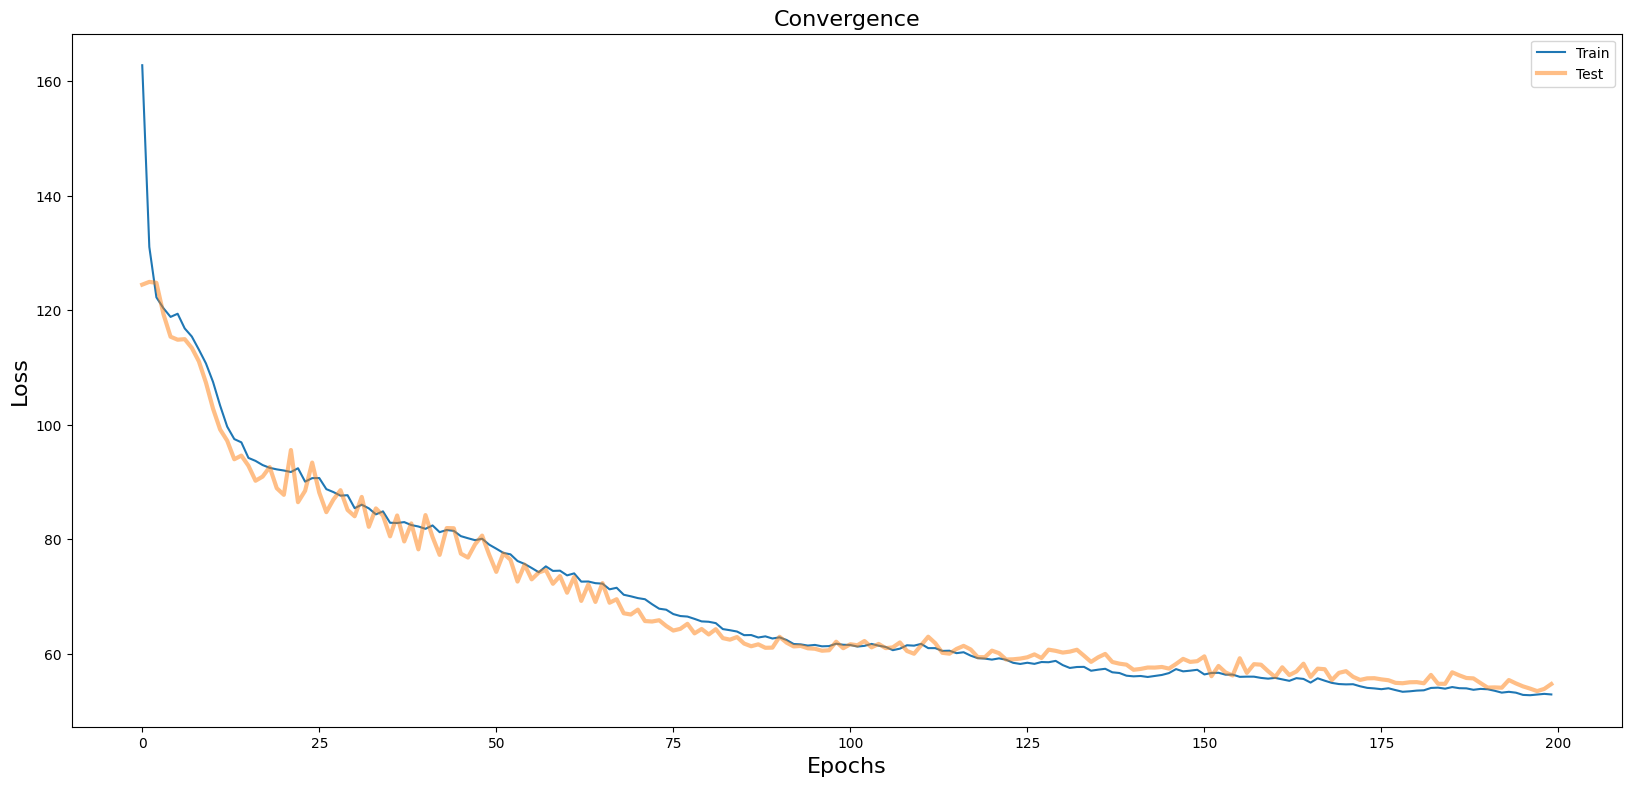

In [26]:

plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()